In [86]:
import numpy as np
from matplotlib.image import imread
import pywt
import matplotlib.pyplot as plt
import cv2
import itertools
import os
import pandas as pd
import time
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

## Test on Set14/Set5/Urban100/Manga109/BSD100

### Loading images

In [72]:
# Loading ALL images, really all
file_paths = []  
for root, dirs, files in os.walk("../../data/Set5"):
    for file in files:
        if file != '.DS_Store':
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

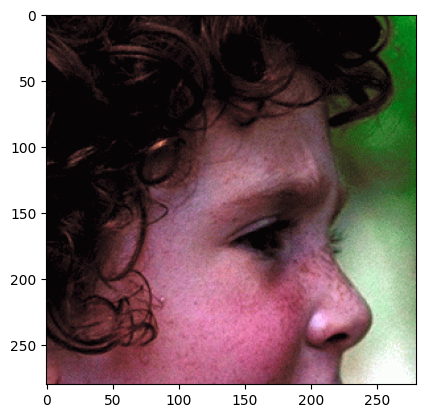

In [74]:
plt.imshow(imread(file_paths[2]))
plt.show()

In [75]:
def compress_image_with_pywt(image_path, wavelet='haar', level=2):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    coeffs = pywt.wavedec2(img, wavelet, mode="antireflect",  level=level)  

    coeffs_thresh = []
    coeffs_thresh.append(coeffs[0])
    for detail_coeffs in coeffs[1:]: 
        h, v, d = detail_coeffs
        h_thresh = pywt.threshold(h, np.inf, mode='hard')
        v_thresh = pywt.threshold(v, np.inf, mode='hard')
        d_thresh = pywt.threshold(d, np.inf, mode='hard')
        coeffs_thresh.append((h_thresh, v_thresh, d_thresh))
    
    reconstructed_img = pywt.waverec2(coeffs_thresh, wavelet)
    # cv2.imwrite('compressed_reconstructed_image.jpeg', reconstructed_img)
    normalized_image = reconstructed_img
    return normalized_image, 4**level


In [87]:
maximum_level = 6
# using most common wavelets 
wavelets = ["haar","sym10" ,"sym2", "bior4.4", "db10", "coif10", "db20", "rbio3.5"]
keep = 0.99  # we will keep 70% of data
# data for plotting
data = [] 

psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}
times = {wavelet: [] for wavelet in wavelets}

In [89]:
for level in range(maximum_level):
    local_psnr_values = []
    local_compressions = []
    local_ssims = []
    local_times = []
    for wave_index, wave in enumerate(wavelets):
        for image_path in file_paths:
            base_image =  np.mean(imread(image_path)*255, -1)
            start_time = time.perf_counter()
            reconstructed_image, compression_rate = compress_image_with_pywt(image_path, wavelet=wave, level=level)
            end_time = time.perf_counter()
            if reconstructed_image.shape[0] == base_image.shape[0] and reconstructed_image.shape[1] == base_image.shape[1]:
                psnr_metric = psnr(base_image, reconstructed_image, data_range=base_image.max() - reconstructed_image.min())
                ssim_metric = ssim(base_image, reconstructed_image, data_range=base_image.max() - reconstructed_image.min())
            
            # psnr_values[wave].append(psnr_metric)
            # compressions[wave].append(compression_rate)
            # ssims[wave].append(ssim_metric)
            local_times.append(end_time - start_time)
            local_psnr_values.append(psnr_metric)
            local_compressions.append(compression_rate)
            local_ssims.append(ssim_metric)
        
        times[wave].append(np.mean(local_times))
        psnr_values[wave].append(np.mean(local_psnr_values))
        compressions[wave].append(np.mean(local_compressions))
        ssims[wave].append(np.mean(local_ssims))

/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


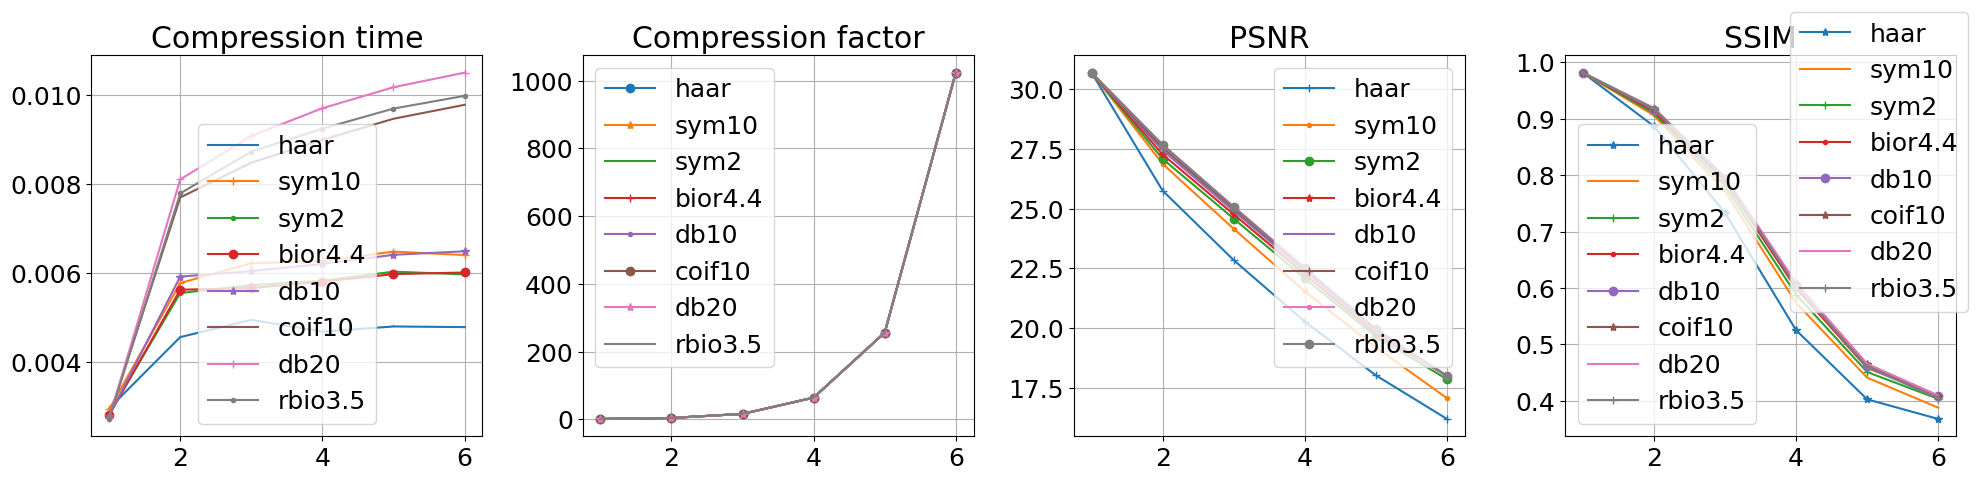

In [95]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 18})

# Sample data for plotting
x = np.linspace(0, 10, 100)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5)) # 1 row, 4 columns
marker = itertools.cycle((',', '+', '.', 'o', '*')) 


# Compression time
for wavelet in wavelets:
    axs[0].plot(np.arange(1, maximum_level+1), times[wavelet],label=wavelet, marker=next(marker))
    axs[0].set_title('Compression time')
    axs[0].grid('on')
    # axs[0].legend()

# Compression factor
for wavelet in wavelets:
    axs[1].plot(np.arange(1, maximum_level+1),  compressions[wavelet],label=wavelet, marker=next(marker))
    axs[1].set_title('Compression factor')
    axs[1].grid('on')
    # axs[1].legend()

# PSNR
for wavelet in wavelets:
    axs[2].plot(np.arange(1, maximum_level+1), psnr_values[wavelet], label=wavelet, marker=next(marker))
    axs[2].set_title('PSNR')
    axs[2].grid('on')
    # axs[2].legend()

   # axs[2].set_ylim(-10, 10) # Limit y-axis to make tan(x) more visible

# SSIM
for wavelet in wavelets:
    axs[3].plot(np.arange(1, maximum_level+1),  ssims[wavelet], label=wavelet, marker=next(marker))
    axs[3].set_title('SSIM')
    axs[3].grid('on')
    # axs[3].legend()
    handles, labels = axs[3].get_legend_handles_labels()


fig.legend(handles, labels, loc='upper right')
# Display the plots
plt.tight_layout() # Adjust the layout to make sure there's no overlap
plt.show()

In [71]:
len(compressions['haar'])

97

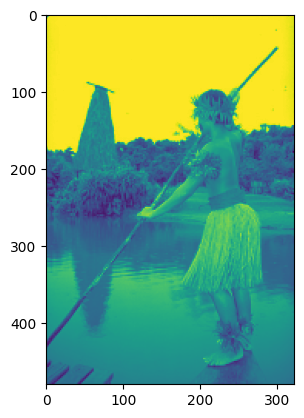

In [55]:
plt.imshow(reconstructed_image)
plt.show()